In [1]:
from riotwatcher import LolWatcher, ApiError
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import kmeans_plusplus, KMeans, SpectralClustering, DBSCAN
import numpy as np
from sklearn.metrics.cluster import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from collections import Counter, defaultdict
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("../DataExtracted/ElyoyaDataV2.csv")
df

,gameId,timestamp,coordinate_x,coordinate_y,team,won
0,EUW1_6176366691,0.000000,557,345,Blue,True
1,EUW1_6176366691,1.000250,5633,9332,Blue,True
2,EUW1_6176366691,2.000750,8149,2265,Blue,True
3,EUW1_6176366691,3.001350,11532,4753,Blue,True
4,EUW1_6176366691,4.001617,11454,3261,Blue,True
...,...,...,...,...,...,...
2006,EUW1_6151765282,28.007417,10665,10235,Red,False
2007,EUW1_6151765282,29.007850,9714,5255,Red,False
2008,EUW1_6151765282,30.007983,7293,10934,Red,False
2009,EUW1_6151765282,31.008533,12258,8480,Red,False


Now that the data is collected from the riot API, I will start by seeing if there are any irregularities in the data.

Here the value_counts() function will be used because besides giving the information on how many player positions were collected in each match, it gives information on the games that were remaked and therefore will be removed. 

In [3]:
pd.set_option("display.max_rows", None)

df["gameId"].value_counts()

EUW1_6155602476    42
EUW1_6156430957    42
EUW1_6154372504    40
EUW1_6156848197    36
EUW1_6160920662    36
EUW1_6162595161    35
EUW1_6154165838    35
EUW1_6156713548    35
EUW1_6160614714    35
EUW1_6169361919    34
EUW1_6166201683    34
EUW1_6160122620    33
EUW1_6151765282    33
EUW1_6167017540    32
EUW1_6166266685    32
EUW1_6164815806    32
EUW1_6174116009    31
EUW1_6156559340    31
EUW1_6166357478    31
EUW1_6162519044    31
EUW1_6165754722    31
EUW1_6169720779    30
EUW1_6165735683    30
EUW1_6154019544    30
EUW1_6155233283    30
EUW1_6155459687    30
EUW1_6161351421    30
EUW1_6161484250    30
EUW1_6176366691    30
EUW1_6154082054    29
EUW1_6163819437    29
EUW1_6156652620    29
EUW1_6163695569    29
EUW1_6161274781    28
EUW1_6174897746    28
EUW1_6163920728    28
EUW1_6160146060    28
EUW1_6169332619    28
EUW1_6173376101    27
EUW1_6156508218    26
EUW1_6161529208    26
EUW1_6151839599    26
EUW1_6163787785    26
EUW1_6169961548    26
EUW1_6175455388    25
EUW1_61544

In [4]:
pd.set_option("display.max_rows", 10)

Looking at the number of player positions in each match, two games stood out for having less than 10 positions. Since the position of the player is collected every minute, this means that these two games have less than 10 minutes, and therefore means that the games did not happen (one team had a player that wasn't playing, which means that this team could give up the game)

With this being said, here EUW1_6166180735 and EUW1_6166247020 will be removed from the data frame.

In [5]:
df.drop(df[df['gameId'] == "EUW1_6166247020"].index, inplace = True)
df.drop(df[df['gameId'] == "EUW1_6166180735"].index, inplace = True)
df

,gameId,timestamp,coordinate_x,coordinate_y,team,won
0,EUW1_6176366691,0.000000,557,345,Blue,True
1,EUW1_6176366691,1.000250,5633,9332,Blue,True
2,EUW1_6176366691,2.000750,8149,2265,Blue,True
3,EUW1_6176366691,3.001350,11532,4753,Blue,True
4,EUW1_6176366691,4.001617,11454,3261,Blue,True
...,...,...,...,...,...,...
2006,EUW1_6151765282,28.007417,10665,10235,Red,False
2007,EUW1_6151765282,29.007850,9714,5255,Red,False
2008,EUW1_6151765282,30.007983,7293,10934,Red,False
2009,EUW1_6151765282,31.008533,12258,8480,Red,False


---

In [6]:
def drawSillouette(X, labels, header="" ):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)

    fig = plt.figure(figsize=(10,8))
    ax1 = plt.gca()
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    silhouette_values = silhouette_samples(X, labels)
    for i,c in enumerate(clusters):
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        #color = np.array(["blueviolet", "yellow", "lime", "crimson"])[i] #
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3  # 10 for the 0 samples
    ax1.set_title("Silhouette plot "+ header)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Clusters")
    ax1.axvline(x=sil_avg, c="r", linestyle="--")

    ax1.set_yticks([]) 
    plt.show()

In [30]:
def clustering(df):
    centroids = np.array([[8250, 4250], [4000, 8750],[12000, 7500], [7750, 12000]])
    nc = df.shape[1]
    df_array = df.values
    X2 = df_array[:, 2:4]
    X = df_array[:, 1:4]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    dbscanLabels = DBSCAN(min_samples=2, eps= 1).fit(X_scaled)
    dbscan = DBSCAN(min_samples=2, eps= 1).fit_predict(X_scaled)
    #2, 0.55 - sem timestamp | 2, 0.9 ou 1 - com timestamp 
    #label = dbscan.fit_predict(X_scaled)

    #---------------
    #plot clusters
    u_labels = np.unique(dbscan)
    img = plt.imread("../map11.png")
    fig, ax = plt.subplots()
    ax.imshow(img, extent=[0, 16000, 0, 16000])

    labels = np.unique(dbscan)

    print(labels)

    for label in labels:
        print("| Cluster {}|".format(label))
        print("Number of points in the cluster: ", len(set(X[dbscan == label, 0])), "\n")
        print("Max Timestamp: {}".format(np.max(X[dbscan == label, 0])))
        print("Min Timestamp: {}".format(np.min(X[dbscan == label, 0])))
        print("Mean Timestamp: {}\n".format(np.mean(X[dbscan == label, 0])))

        print("Max position: (x:{}, y:{})".format(np.max(X[dbscan == label, 1]), np.max(X[dbscan == label, 2]) ))
        print("Min position: (x:{}, y:{})".format(np.min(X[dbscan == label, 1]), np.min(X[dbscan == label, 2])))
        print("Mean position: (x:{}, y:{})\n".format(np.mean(X[dbscan == label, 1]), np.mean(X[dbscan == label, 2])))

        text = "-"
        print(f"{text:-^80}\n")
    
    #plotting the results:
    
    for i in u_labels:
        ax.scatter(X2[dbscan == i , 0] , X2[dbscan == i , 1] , label = i)
    ax.legend(frameon = True)
    plt.grid(visible=None)
    plt.show()

    drawSillouette(X_scaled, dbscanLabels.labels_, "kmeans (K=4)")

    print("Kmeans silhouette_score", silhouette_score(X_scaled, dbscanLabels.labels_))
    print("--------------------------------------------------------------------------------------")

In [8]:
df.drop(df[(df['coordinate_x'] <= 6000) & (df["coordinate_y"] <= 6000)].index, inplace = True)
df.drop(df[(df['coordinate_x'] >= 10500) & (df["coordinate_y"] >= 10500)].index, inplace = True)
df

,gameId,timestamp,coordinate_x,coordinate_y,team,won
1,EUW1_6176366691,1.000250,5633,9332,Blue,True
2,EUW1_6176366691,2.000750,8149,2265,Blue,True
3,EUW1_6176366691,3.001350,11532,4753,Blue,True
4,EUW1_6176366691,4.001617,11454,3261,Blue,True
5,EUW1_6176366691,5.001633,1232,13514,Blue,True
...,...,...,...,...,...,...
2005,EUW1_6151765282,27.007400,7572,12304,Red,False
2006,EUW1_6151765282,28.007417,10665,10235,Red,False
2007,EUW1_6151765282,29.007850,9714,5255,Red,False
2008,EUW1_6151765282,30.007983,7293,10934,Red,False


In [9]:
redTeam_df = df.loc[df["team"] == "Red"]
print("Red Team Data Frame:\n{}".format(redTeam_df))
print("\nElyoya played {} matches on the red team.".format(redTeam_df["gameId"].nunique()))

Red Team Data Frame:
               gameId  timestamp  coordinate_x  coordinate_y team    won
31    EUW1_6176325099   1.000250          9667          7063  Red  False
32    EUW1_6176325099   2.000350          8037          3520  Red  False
33    EUW1_6176325099   3.000583         11663          7725  Red  False
34    EUW1_6176325099   4.000900          7672          5223  Red  False
35    EUW1_6176325099   5.001633          3604         13800  Red  False
...               ...        ...           ...           ...  ...    ...
2005  EUW1_6151765282  27.007400          7572         12304  Red  False
2006  EUW1_6151765282  28.007417         10665         10235  Red  False
2007  EUW1_6151765282  29.007850          9714          5255  Red  False
2008  EUW1_6151765282  30.007983          7293         10934  Red  False
2009  EUW1_6151765282  31.008533         12258          8480  Red  False

[756 rows x 6 columns]

Elyoya played 33 matches on the red team.


In [10]:
redTeamWins_df = redTeam_df.loc[redTeam_df["won"] == True]
print("Red Team Winning Data Frame:\n{}".format(redTeamWins_df))

print("\nElyoya won {} matches on the red team.".format(redTeamWins_df["gameId"].nunique()))

Red Team Winning Data Frame:
               gameId  timestamp  coordinate_x  coordinate_y team   won
160   EUW1_6173376101   1.000200          7269          9759  Red  True
161   EUW1_6173376101   2.000483          7219         12424  Red  True
162   EUW1_6173376101   3.001183         11854          6708  Red  True
163   EUW1_6173376101   4.001733         10439         13946  Red  True
164   EUW1_6173376101   5.002283          3693          6591  Red  True
...               ...        ...           ...           ...  ...   ...
1860  EUW1_6154165838  27.008967         10968          8450  Red  True
1861  EUW1_6154165838  28.009083          8532          4744  Red  True
1862  EUW1_6154165838  29.009500          7563          9749  Red  True
1865  EUW1_6154165838  32.010183          7520          7674  Red  True
1866  EUW1_6154165838  33.010350          9017          6192  Red  True

[387 rows x 6 columns]

Elyoya won 17 matches on the red team.


In [11]:
df_array = redTeamWins_df.values
X = df_array[:, 1:4]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#checking the parameters for DBSCAN
for eps in [0.05, 0.1, 0.15,0.2,0.25, 0.3,0.35, 0.4,0.45, 0.5,0.55, 0.6, 0.65, 0.7,0.75, 0.8,0.85, 0.9, 1]:
    for Nmin in [2, 3, 4, 5,6, 7, 8, 9, 10, 1, 15, 20, 30, 50]:
        db = DBSCAN(eps=eps, min_samples=Nmin).fit(X_scaled)
        nclusts=len(set(db.labels_))
        if nclusts>1:
            #Remember that the first cluster is NOISE!!! [-1]
            print("NMin: %2d Eps: %4.2f NClusters: %2d" %(Nmin, eps, nclusts), "-->", np.bincount(1+ db.labels_))


NMin:  2 Eps: 0.05 NClusters: 12 --> [350   5   4   6   2   2   7   2   2   3   2   2]
NMin:  3 Eps: 0.05 NClusters:  6 --> [362   5   4   6   7   3]
NMin:  4 Eps: 0.05 NClusters:  4 --> [371   5   4   7]
NMin:  5 Eps: 0.05 NClusters:  3 --> [375   5   7]
NMin:  1 Eps: 0.05 NClusters: 361 --> [0 5 4 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 3 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [12]:
for game in redTeamWins_df.gameId.unique():
    game_df = df.loc[df["gameId"] == game]
    df_array = game_df.values
    X = df_array[:, 1:4]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    #checking the parameters for DBSCAN
    for eps in [0.05, 0.1, 0.15,0.2,0.25, 0.3,0.35, 0.4,0.45, 0.5,0.55, 0.6, 0.65, 0.7,0.75, 0.8,0.85, 0.9, 1]:
        for Nmin in [2, 3, 4, 5,6, 7, 8, 9, 10, 1, 15, 20, 30, 50]:
            db = DBSCAN(eps=eps, min_samples=Nmin).fit(X_scaled)
            nclusts=len(set(db.labels_))
            if nclusts>1:
                #Remember that the first cluster is NOISE!!! [-1]
                print("NMin: %2d Eps: %4.2f NClusters: %2d" %(Nmin, eps, nclusts), "-->", np.bincount(1+ db.labels_))
    print("-------------------------------------------------------------------------------------\n")


NMin:  1 Eps: 0.05 NClusters: 24 --> [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NMin:  1 Eps: 0.10 NClusters: 24 --> [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NMin:  1 Eps: 0.15 NClusters: 24 --> [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NMin:  1 Eps: 0.20 NClusters: 24 --> [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NMin:  1 Eps: 0.25 NClusters: 24 --> [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NMin:  1 Eps: 0.30 NClusters: 24 --> [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NMin:  1 Eps: 0.35 NClusters: 24 --> [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NMin:  2 Eps: 0.40 NClusters:  3 --> [20  2  2]
NMin:  1 Eps: 0.40 NClusters: 22 --> [0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1]
NMin:  2 Eps: 0.45 NClusters:  3 --> [20  2  2]
NMin:  1 Eps: 0.45 NClusters: 22 --> [0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1]
NMin:  2 Eps: 0.50 NClusters:  4 --> [18  2  2  2]
NMin:  1 Eps: 0.50 NClusters: 21 --> [0 1 1 1 1 1 1 1 1 1 1 

1: EUW1_6173376101 - Red team Victory
Number of points:  24
[-1  0  1]
| Cluster -1|
Number of points in the cluster:  5 

Max Timestamp: 23.00838333333333
Min Timestamp: 4.001733333333333
Mean Timestamp: 10.804173333333333

Max position: (x:12077, y:13946)
Min position: (x:1044, y:1326)
Mean position: (x:6825.8, y:7153.4)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  12 

Max Timestamp: 24.008466666666667
Min Timestamp: 1.0002
Mean Timestamp: 13.338265277777777

Max position: (x:8535, y:12712)
Min position: (x:3718, y:6201)
Mean position: (x:6026.416666666667, y:9716.25)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  7 

Max Timestamp: 18.006916666666665
Min Timestamp: 3.001183333333333
Mean Timestamp: 12.290400000000002

Max position: (x:13564, y:7738)
Min position: (x:9964, y:4657)
Mean position: (x:11522.42857142857, 

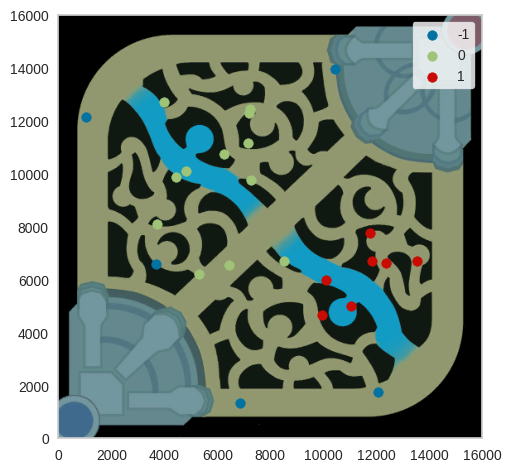

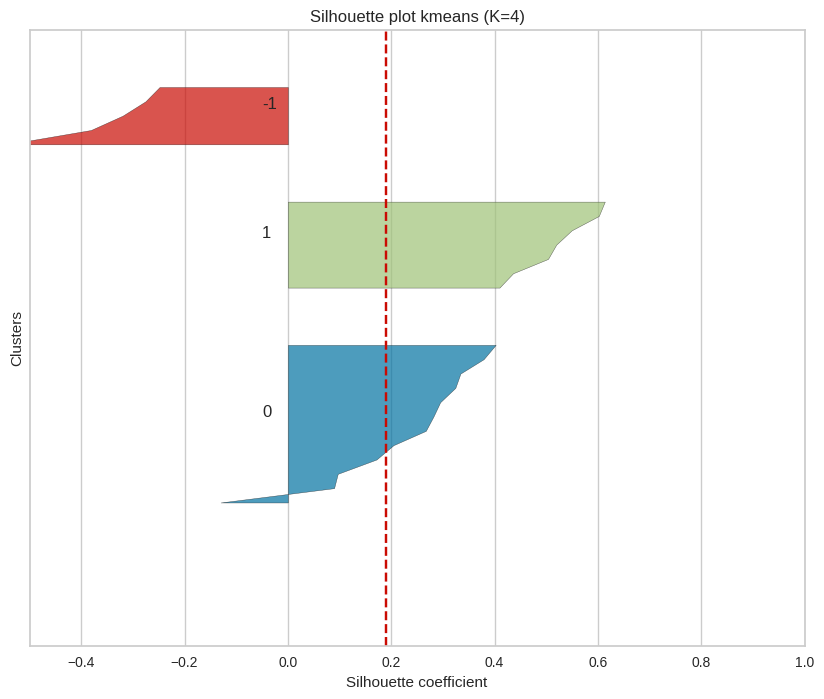

Kmeans silhouette_score 0.19072112810805375
--------------------------------------------------------------------------------------
2: EUW1_6170116709 - Red team Victory
Number of points:  18
[-1  0  1  2  3  4]
| Cluster -1|
Number of points in the cluster:  3 

Max Timestamp: 16.005216666666666
Min Timestamp: 11.003466666666666
Mean Timestamp: 13.671105555555556

Max position: (x:11391, y:7739)
Min position: (x:906, y:1180)
Mean position: (x:6803.333333333333, y:3555.6666666666665)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  5 

Max Timestamp: 13.004116666666668
Min Timestamp: 1.000033333333333
Mean Timestamp: 6.4020600000000005

Max position: (x:8753, y:12232)
Min position: (x:5484, y:9787)
Mean position: (x:7340.8, y:10945.8)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  2 

Max Timestamp: 6.00245
Min Timestamp: 3.0

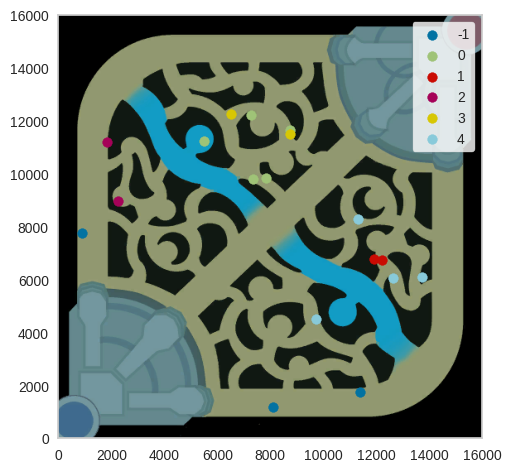

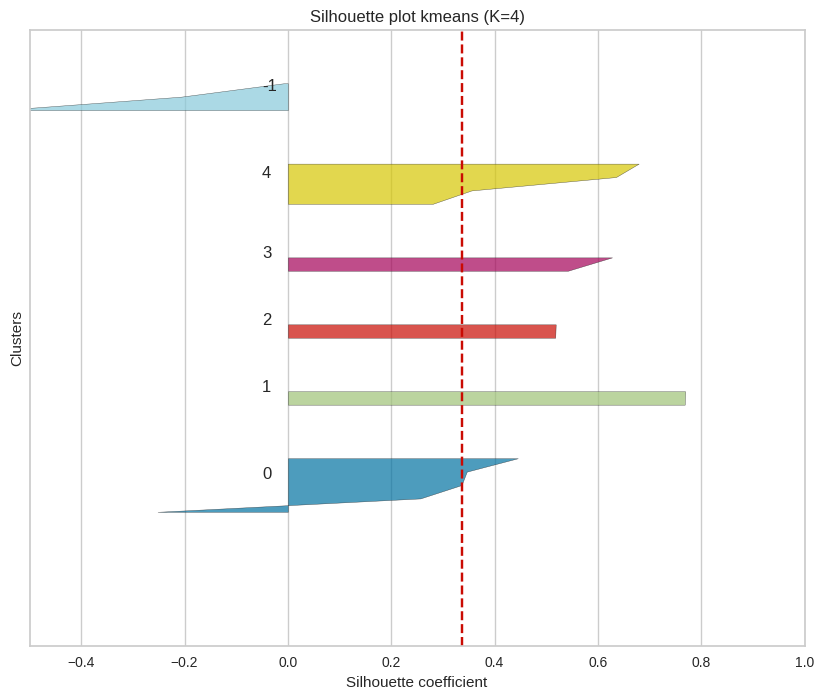

Kmeans silhouette_score 0.3361241333669625
--------------------------------------------------------------------------------------
3: EUW1_6169961548 - Red team Victory
Number of points:  18
[-1  0  1  2]
| Cluster -1|
Number of points in the cluster:  7 

Max Timestamp: 22.0059
Min Timestamp: 2.00075
Mean Timestamp: 8.716921428571428

Max position: (x:12058, y:12517)
Min position: (x:4594, y:6606)
Mean position: (x:7635.0, y:9813.42857142857)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  3 

Max Timestamp: 13.003633333333331
Min Timestamp: 7.002183333333333
Mean Timestamp: 10.003033333333333

Max position: (x:12103, y:6219)
Min position: (x:10426, y:4634)
Mean position: (x:11240.0, y:5318.0)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  6 

Max Timestamp: 20.0052
Min Timestamp: 11.0033
Mean Timestamp: 15.504155555555556


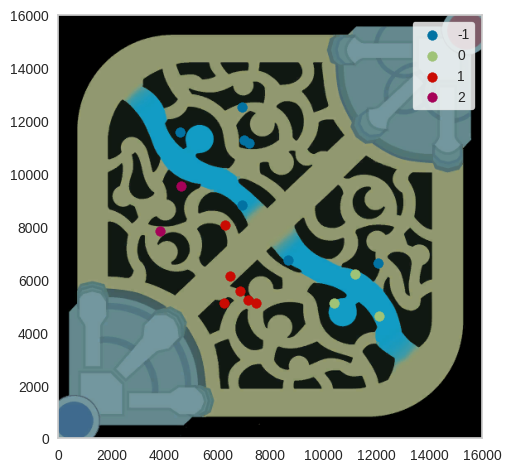

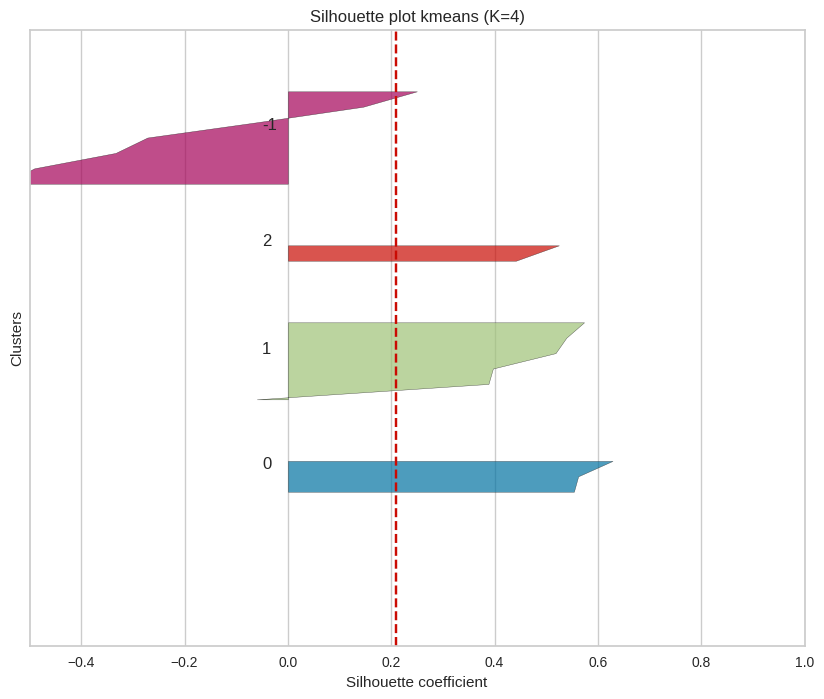

Kmeans silhouette_score 0.208697244511432
--------------------------------------------------------------------------------------
4: EUW1_6169756315 - Red team Victory
Number of points:  15
[-1  0  1  2  3]
| Cluster -1|
Number of points in the cluster:  6 

Max Timestamp: 14.003566666666666
Min Timestamp: 1.00005
Mean Timestamp: 5.668063888888889

Max position: (x:12266, y:12431)
Min position: (x:1113, y:1254)
Mean position: (x:7241.333333333333, y:7416.0)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  2 

Max Timestamp: 5.001233333333333
Min Timestamp: 4.001016666666667
Mean Timestamp: 4.501125

Max position: (x:7053, y:9077)
Min position: (x:5849, y:6511)
Mean position: (x:6451.0, y:7794.0)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  2 

Max Timestamp: 11.0029
Min Timestamp: 7.001766666666667
Mean Timestamp: 9.0023333

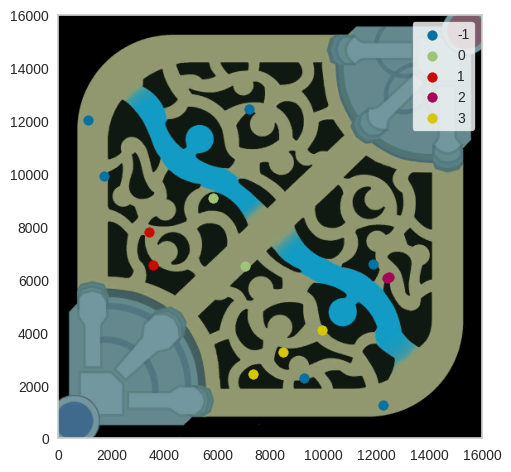

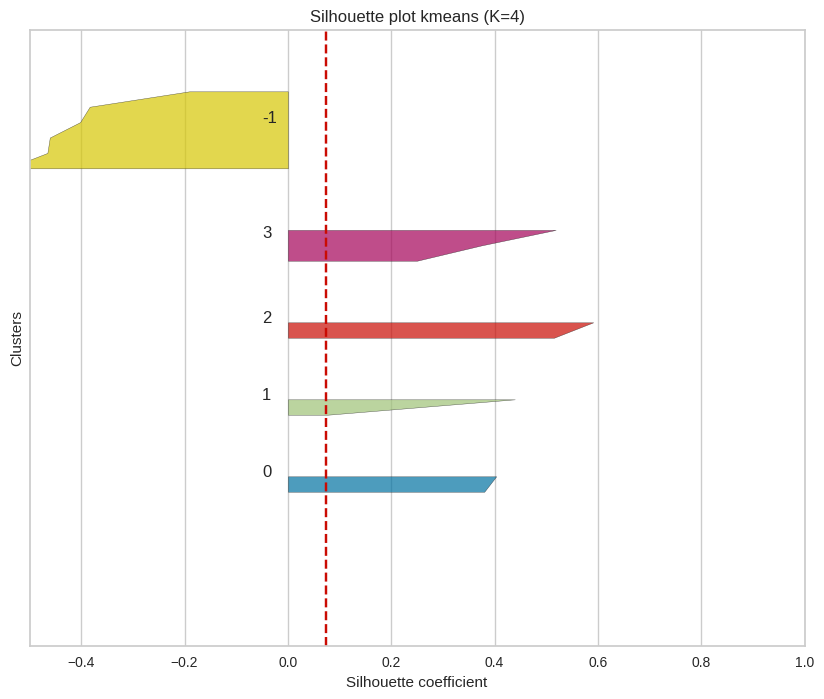

Kmeans silhouette_score 0.07353407896476259
--------------------------------------------------------------------------------------
5: EUW1_6169361919 - Red team Victory
Number of points:  23
[-1  0  1  2  3  4  5]
| Cluster -1|
Number of points in the cluster:  6 

Max Timestamp: 31.0092
Min Timestamp: 3.001333333333333
Mean Timestamp: 13.670850000000002

Max position: (x:10972, y:12289)
Min position: (x:2370, y:1552)
Mean position: (x:5748.666666666667, y:7169.0)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  3 

Max Timestamp: 6.0022166666666665
Min Timestamp: 1.0005333333333333
Mean Timestamp: 3.0012055555555555

Max position: (x:7257, y:12475)
Min position: (x:6392, y:10073)
Mean position: (x:6781.333333333333, y:11578.0)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  3 

Max Timestamp: 16.0047
Min Timestamp: 7.0022666

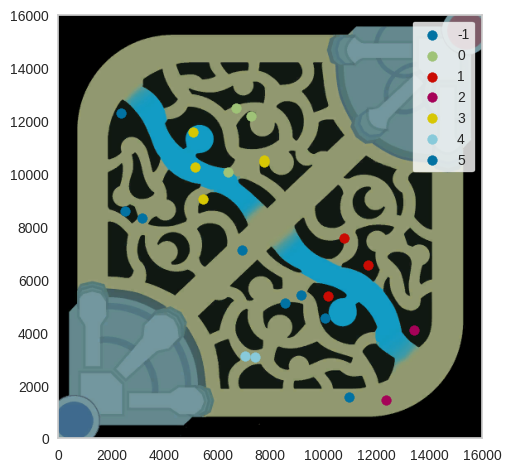

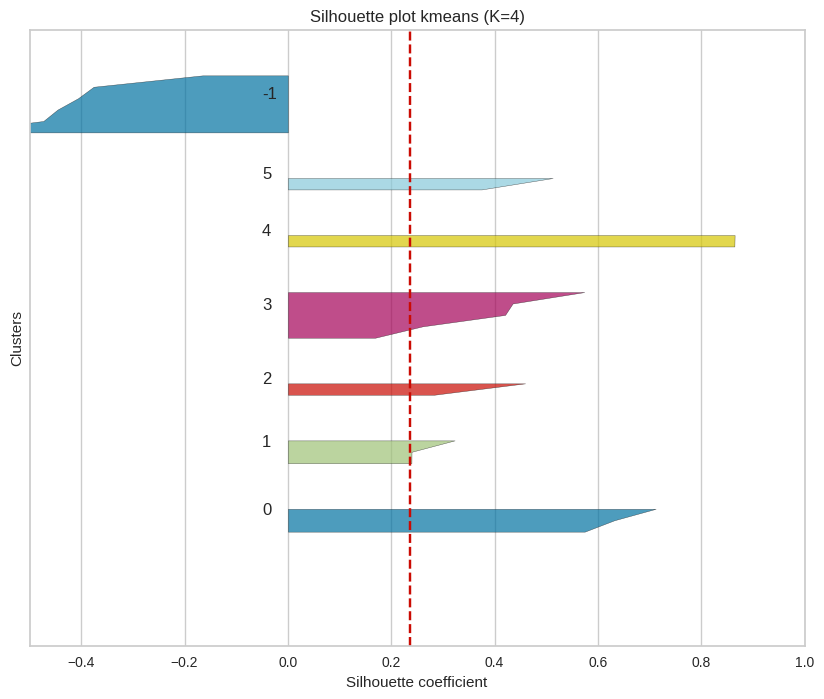

Kmeans silhouette_score 0.2356558604541901
--------------------------------------------------------------------------------------
6: EUW1_6169332619 - Red team Victory
Number of points:  23
[-1  0  1  2  3  4]
| Cluster -1|
Number of points in the cluster:  7 

Max Timestamp: 25.007816666666667
Min Timestamp: 2.0001333333333333
Mean Timestamp: 17.00501904761905

Max position: (x:12279, y:12655)
Min position: (x:1470, y:5576)
Mean position: (x:7982.285714285715, y:9142.57142857143)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  5 

Max Timestamp: 8.001566666666667
Min Timestamp: 1.0001166666666668
Mean Timestamp: 4.6008

Max position: (x:8031, y:11157)
Min position: (x:5551, y:8150)
Mean position: (x:7117.4, y:9515.4)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  3 

Max Timestamp: 14.003816666666667
Min Timestamp: 5.00096

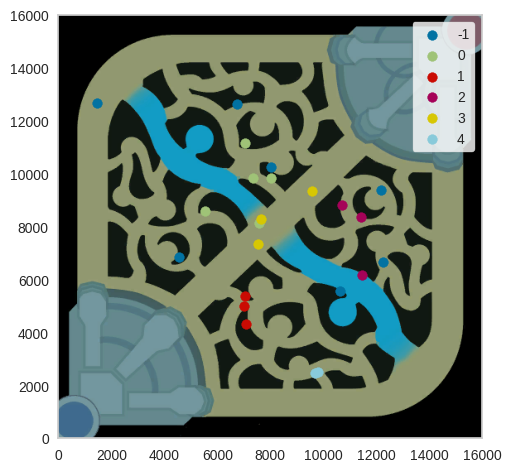

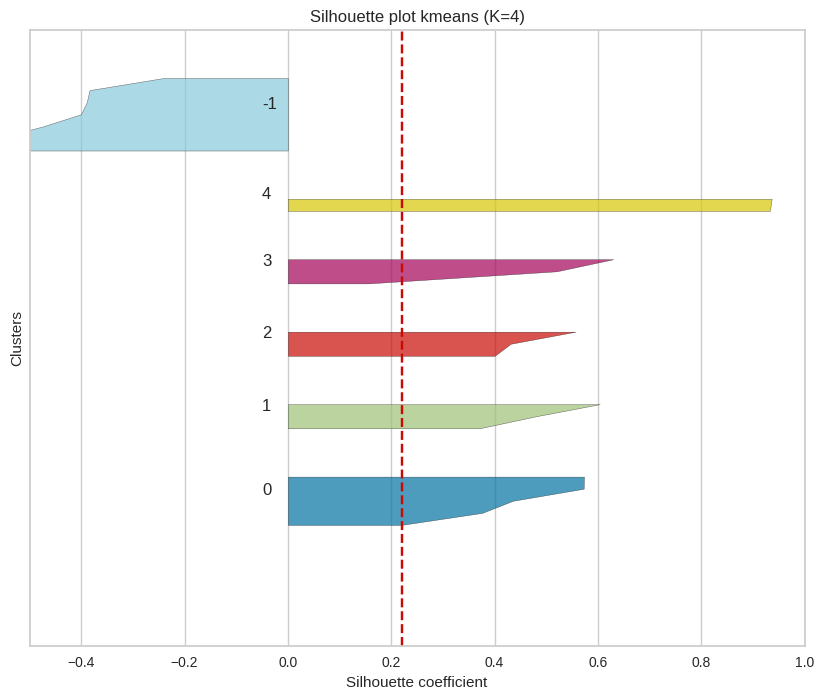

Kmeans silhouette_score 0.22079608061614553
--------------------------------------------------------------------------------------
7: EUW1_6166266685 - Red team Victory
Number of points:  26
[-1  0  1  2  3]
| Cluster -1|
Number of points in the cluster:  5 

Max Timestamp: 27.006433333333334
Min Timestamp: 5.00105
Mean Timestamp: 19.204346666666666

Max position: (x:12413, y:11915)
Min position: (x:1901, y:4283)
Mean position: (x:6037.6, y:8787.4)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  8 

Max Timestamp: 16.003016666666667
Min Timestamp: 1.0005166666666667
Mean Timestamp: 6.876489583333333

Max position: (x:12132, y:12527)
Min position: (x:6677, y:7400)
Mean position: (x:9438.0, y:9725.125)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  3 

Max Timestamp: 12.00235
Min Timestamp: 4.001
Mean Timestamp: 9.00177222222

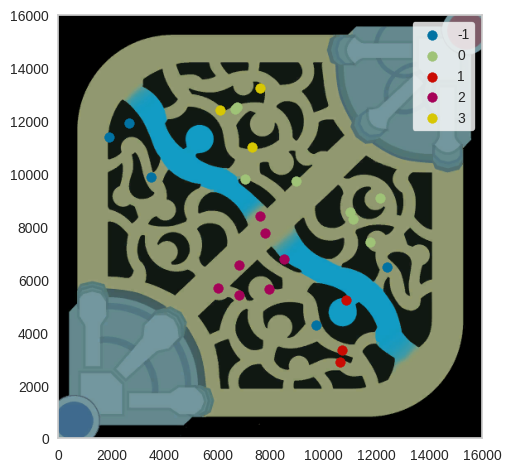

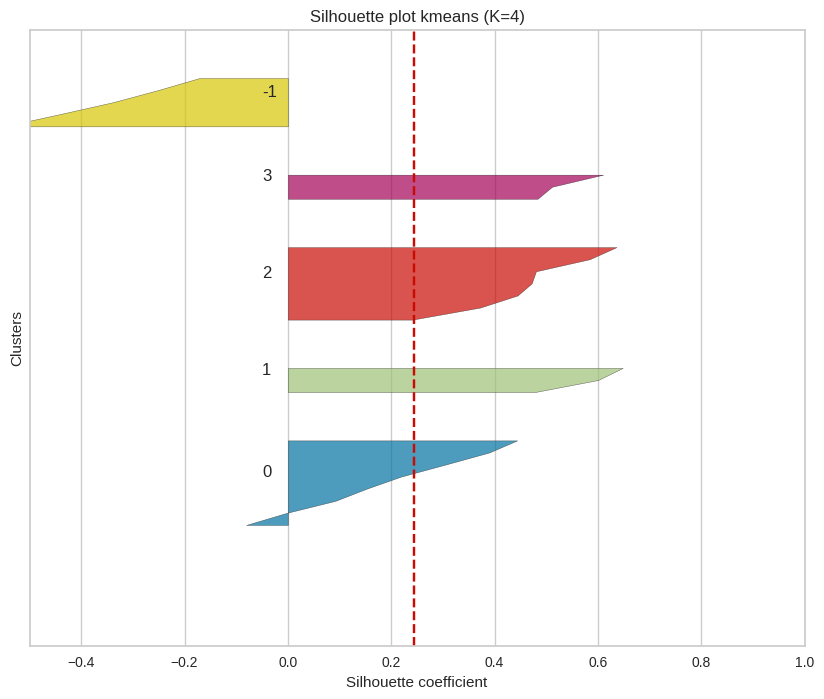

Kmeans silhouette_score 0.24325756547178978
--------------------------------------------------------------------------------------
8: EUW1_6166201683 - Red team Victory
Number of points:  27
[-1  0  1  2  3]
| Cluster -1|
Number of points in the cluster:  6 

Max Timestamp: 23.00563333333333
Min Timestamp: 2.0003333333333333
Mean Timestamp: 11.669411111111112

Max position: (x:12211, y:12785)
Min position: (x:1363, y:2963)
Mean position: (x:7170.0, y:8999.333333333334)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  5 

Max Timestamp: 15.002933333333331
Min Timestamp: 1.000133333333333
Mean Timestamp: 8.601483333333332

Max position: (x:8592, y:9969)
Min position: (x:5016, y:8437)
Mean position: (x:6978.0, y:9231.2)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  6 

Max Timestamp: 18.004583333333333
Min Timestamp: 3.0003833

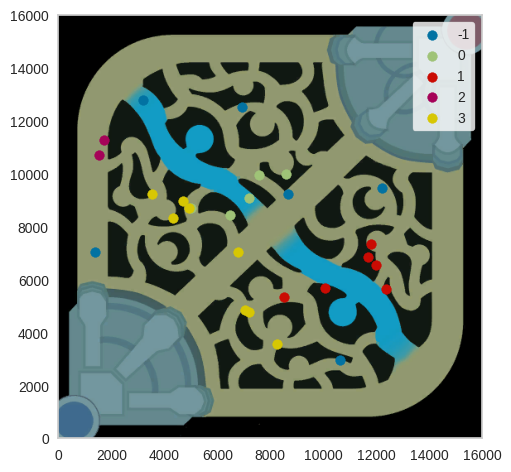

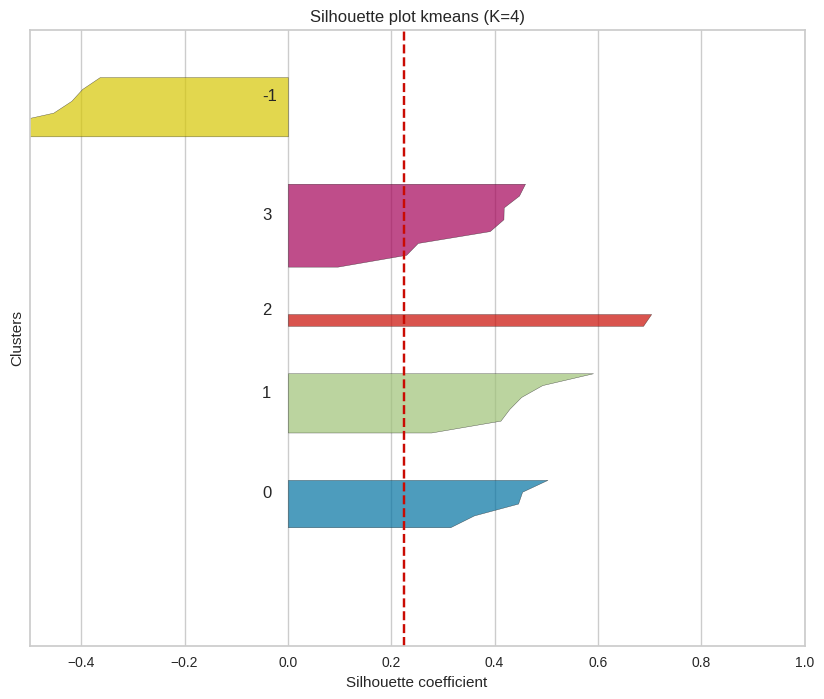

Kmeans silhouette_score 0.22463112710788202
--------------------------------------------------------------------------------------
9: EUW1_6165754722 - Red team Victory
Number of points:  24
[-1  0  1  2  3  4]
| Cluster -1|
Number of points in the cluster:  4 

Max Timestamp: 28.0074
Min Timestamp: 12.002483333333334
Mean Timestamp: 21.755354166666667

Max position: (x:11626, y:7896)
Min position: (x:1713, y:1042)
Mean position: (x:7463.25, y:4918.5)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  4 

Max Timestamp: 7.001283333333333
Min Timestamp: 1.0
Mean Timestamp: 3.750620833333333

Max position: (x:7236, y:12480)
Min position: (x:5568, y:9818)
Mean position: (x:6586.0, y:11491.0)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  3 

Max Timestamp: 11.002283333333333
Min Timestamp: 3.00045
Mean Timestamp: 6.00112222222222

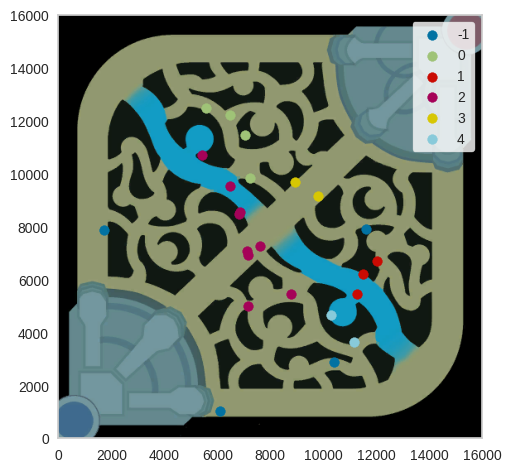

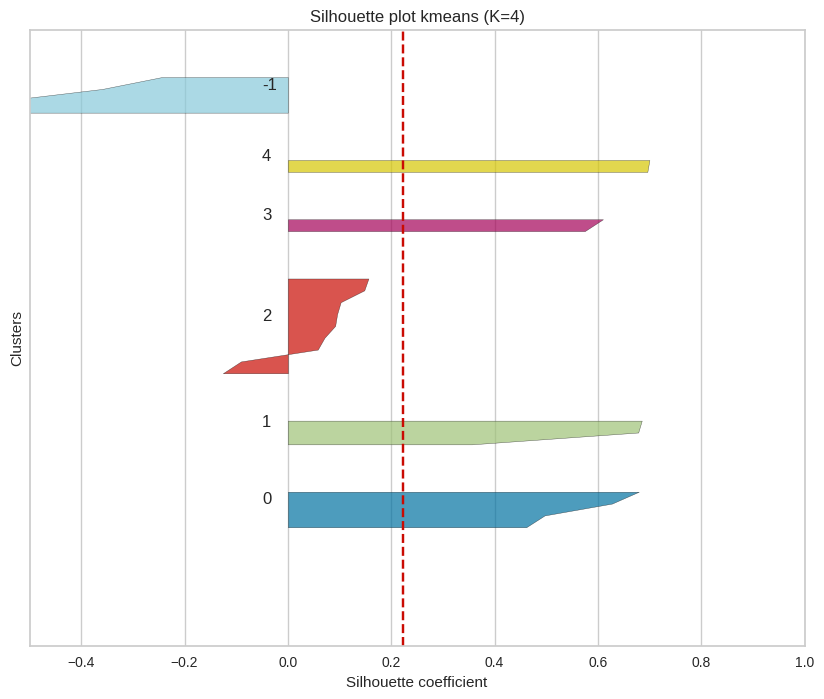

Kmeans silhouette_score 0.22274028048886296
--------------------------------------------------------------------------------------
10: EUW1_6165735683 - Red team Victory
Number of points:  25
[-1  0  1  2  3]
| Cluster -1|
Number of points in the cluster:  4 

Max Timestamp: 27.00778333333333
Min Timestamp: 1.0002833333333334
Mean Timestamp: 12.753645833333332

Max position: (x:8929, y:12542)
Min position: (x:4507, y:7986)
Mean position: (x:6855.0, y:10890.75)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  2 

Max Timestamp: 4.000983333333333
Min Timestamp: 2.0008
Mean Timestamp: 3.0008916666666665

Max position: (x:11579, y:2482)
Min position: (x:10813, y:1298)
Mean position: (x:11196.0, y:1890.0)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  14 

Max Timestamp: 26.007766666666665
Min Timestamp: 3.00085
Mean Timestamp: 1

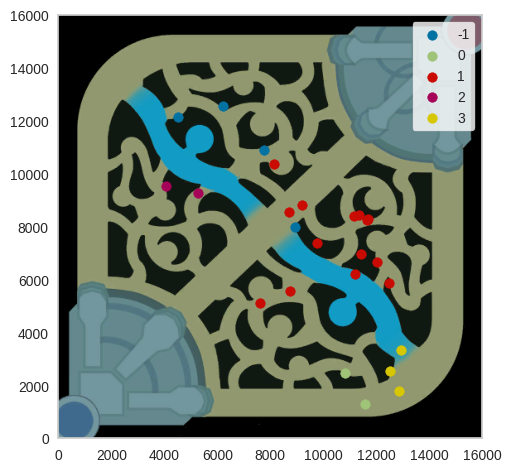

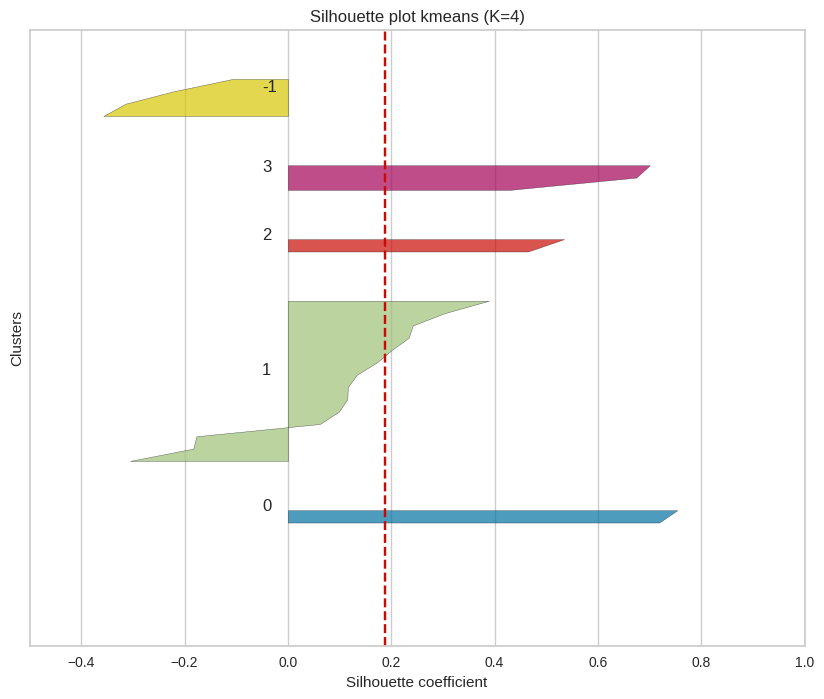

Kmeans silhouette_score 0.18703144613147898
--------------------------------------------------------------------------------------
11: EUW1_6163695569 - Red team Victory
Number of points:  25
[-1  0  1  2  3  4]
| Cluster -1|
Number of points in the cluster:  4 

Max Timestamp: 25.0066
Min Timestamp: 1.0003333333333333
Mean Timestamp: 15.003841666666666

Max position: (x:12072, y:10354)
Min position: (x:6464, y:9210)
Mean position: (x:8833.75, y:9868.5)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  6 

Max Timestamp: 13.002966666666667
Min Timestamp: 2.00035
Mean Timestamp: 8.835225

Max position: (x:7749, y:12406)
Min position: (x:5098, y:7624)
Mean position: (x:6854.333333333333, y:10216.333333333334)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  2 

Max Timestamp: 5.001116666666666
Min Timestamp: 3.0006666666666666
Me

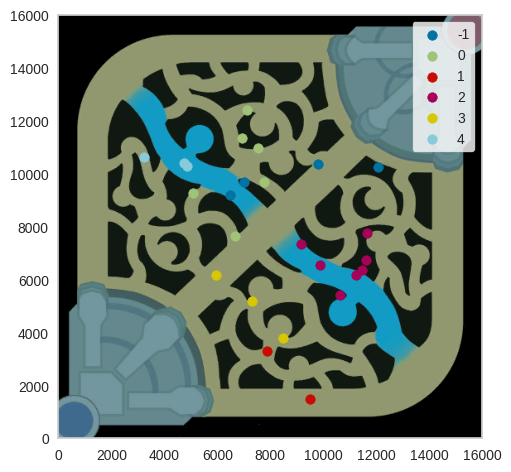

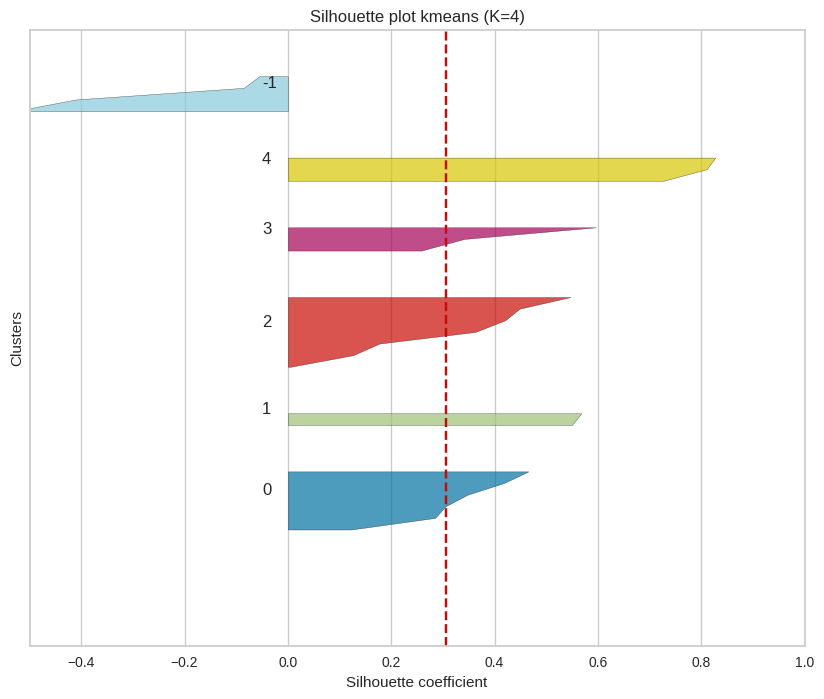

Kmeans silhouette_score 0.305145090589494
--------------------------------------------------------------------------------------
12: EUW1_6163629472 - Red team Victory
Number of points:  18
[0 1 2 3 4 5]
| Cluster 0|
Number of points in the cluster:  2 

Max Timestamp: 2.000583333333333
Min Timestamp: 1.0002666666666666
Mean Timestamp: 1.500425

Max position: (x:7276, y:12550)
Min position: (x:6776, y:9850)
Mean position: (x:7026.0, y:11200.0)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  3 

Max Timestamp: 12.002766666666666
Min Timestamp: 3.0007166666666665
Mean Timestamp: 7.3351

Max position: (x:11874, y:8199)
Min position: (x:11157, y:6680)
Mean position: (x:11555.333333333334, y:7347.666666666667)

--------------------------------------------------------------------------------

| Cluster 2|
Number of points in the cluster:  5 

Max Timestamp: 17.00411666666667
Min Timestamp: 4.001166666666666
Mea

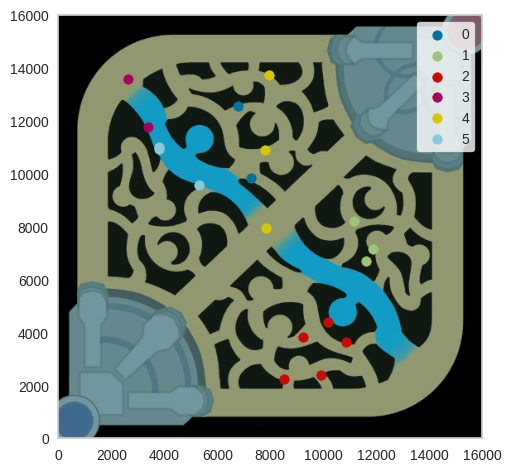

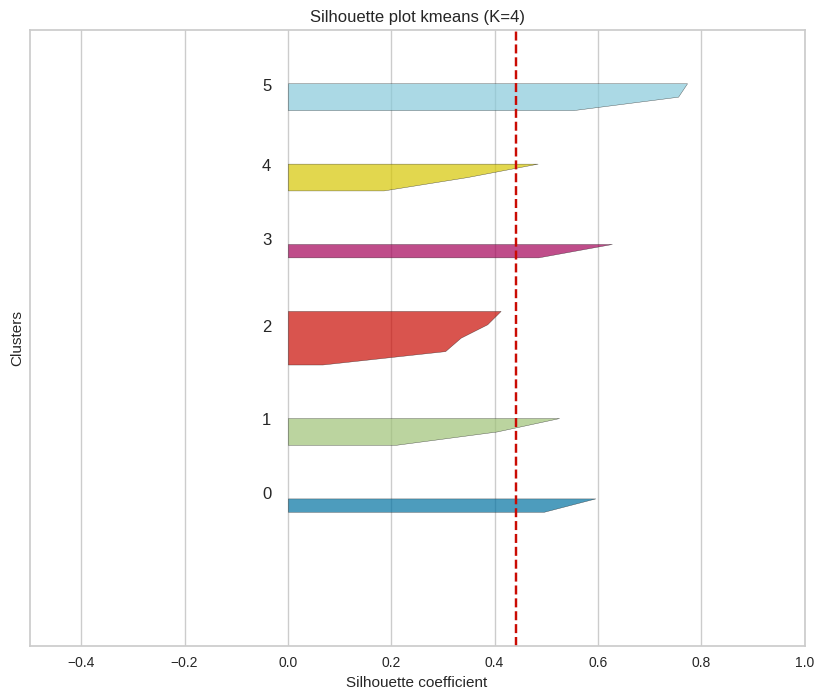

Kmeans silhouette_score 0.44104662675866113
--------------------------------------------------------------------------------------
13: EUW1_6162595161 - Red team Victory
Number of points:  29
[-1  0  1  2  3  4]
| Cluster -1|
Number of points in the cluster:  3 

Max Timestamp: 31.00818333333333
Min Timestamp: 7.00245
Mean Timestamp: 20.672633333333334

Max position: (x:8106, y:12658)
Min position: (x:2063, y:3982)
Mean position: (x:4816.666666666667, y:9447.666666666666)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  5 

Max Timestamp: 11.00345
Min Timestamp: 1.00015
Mean Timestamp: 6.802136666666667

Max position: (x:8919, y:9635)
Min position: (x:3337, y:8148)
Mean position: (x:6073.0, y:8994.0)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  2 

Max Timestamp: 5.001766666666667
Min Timestamp: 2.000566666666667
Mean Time

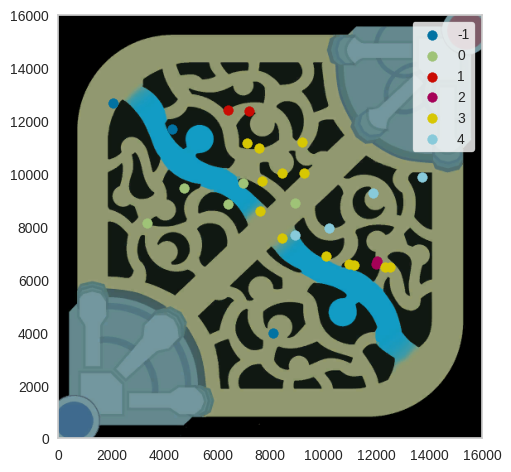

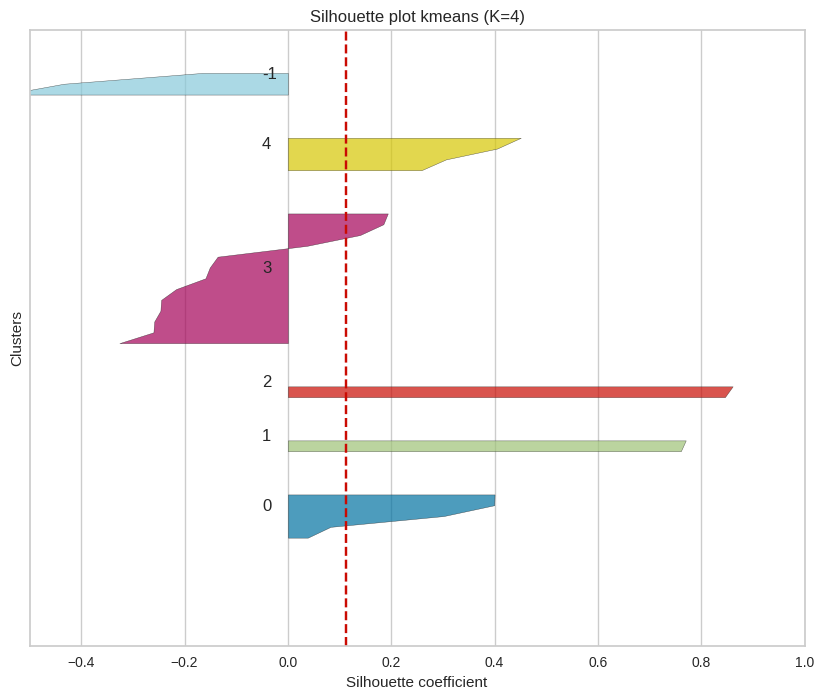

Kmeans silhouette_score 0.11320037951663171
--------------------------------------------------------------------------------------
14: EUW1_6156713548 - Red team Victory
Number of points:  25
[-1  0  1  2  3]
| Cluster -1|
Number of points in the cluster:  4 

Max Timestamp: 29.0088
Min Timestamp: 8.002733333333333
Mean Timestamp: 17.0054125

Max position: (x:9734, y:12014)
Min position: (x:2893, y:1437)
Mean position: (x:6431.75, y:6417.25)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  12 

Max Timestamp: 18.00585
Min Timestamp: 1.0003166666666667
Mean Timestamp: 9.836568055555555

Max position: (x:8630, y:12496)
Min position: (x:2167, y:7215)
Mean position: (x:6078.083333333333, y:9692.916666666666)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  4 

Max Timestamp: 15.004766666666669
Min Timestamp: 3.000833333333333
Mean

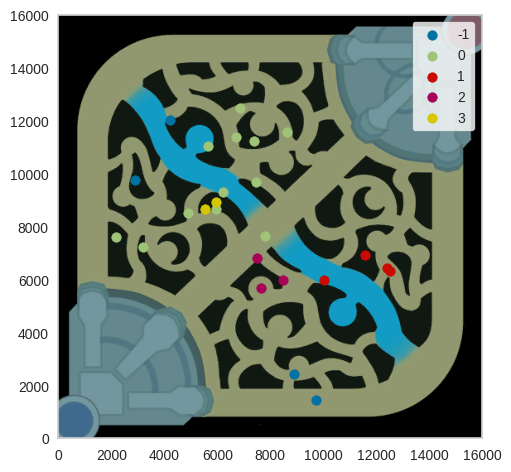

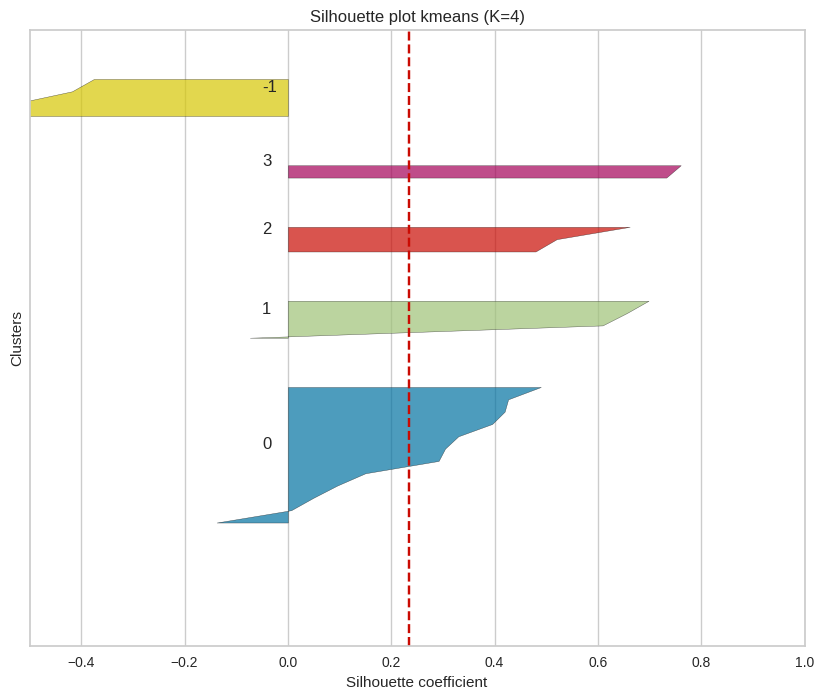

Kmeans silhouette_score 0.2352817816796427
--------------------------------------------------------------------------------------
15: EUW1_6155318816 - Red team Victory
Number of points:  22
[-1  0  1  2  3  4]
| Cluster -1|
Number of points in the cluster:  5 

Max Timestamp: 22.006633333333333
Min Timestamp: 1.00015
Mean Timestamp: 14.604383333333335

Max position: (x:11056, y:8565)
Min position: (x:7989, y:2230)
Mean position: (x:9666.6, y:4452.6)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  5 

Max Timestamp: 16.00485
Min Timestamp: 2.00025
Mean Timestamp: 9.602976666666667

Max position: (x:13010, y:6693)
Min position: (x:11645, y:5142)
Mean position: (x:12200.6, y:6154.0)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  3 

Max Timestamp: 9.003133333333333
Min Timestamp: 3.0004833333333334
Mean Timestamp: 6.001766666

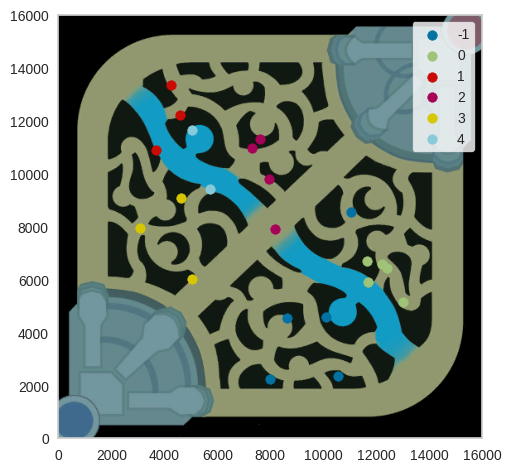

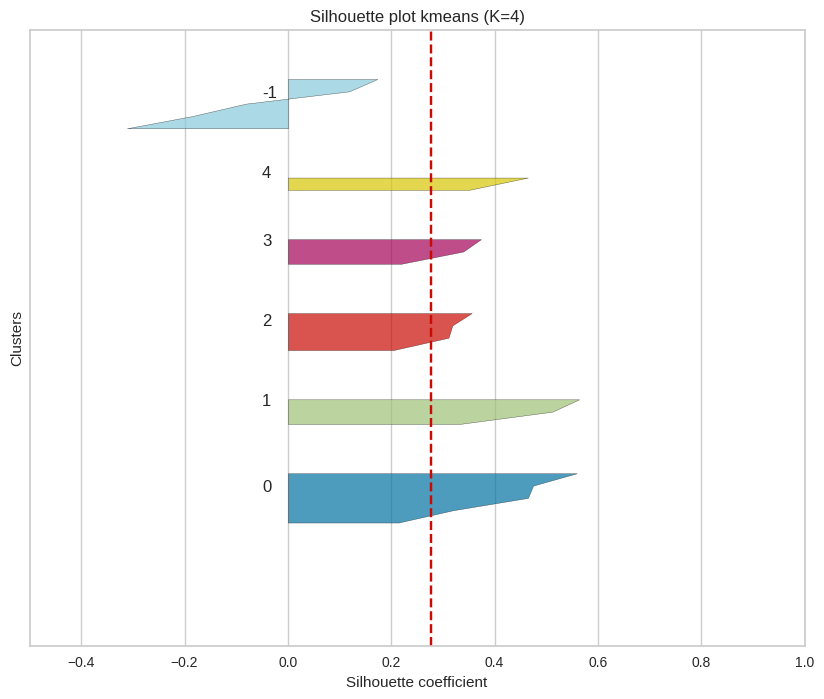

Kmeans silhouette_score 0.2768133902919062
--------------------------------------------------------------------------------------
16: EUW1_6154241292 - Red team Victory
Number of points:  18
[-1  0  1  2  3]
| Cluster -1|
Number of points in the cluster:  6 

Max Timestamp: 21.006466666666668
Min Timestamp: 5.001633333333333
Mean Timestamp: 13.00435

Max position: (x:13068, y:12367)
Min position: (x:1292, y:3725)
Mean position: (x:6859.833333333333, y:7339.5)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  4 

Max Timestamp: 11.003983333333334
Min Timestamp: 1.000133333333333
Mean Timestamp: 6.0018416666666665

Max position: (x:7415, y:10964)
Min position: (x:4859, y:9209)
Mean position: (x:6441.25, y:9870.0)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  3 

Max Timestamp: 9.00295
Min Timestamp: 2.0004666666666666
Mean Tim

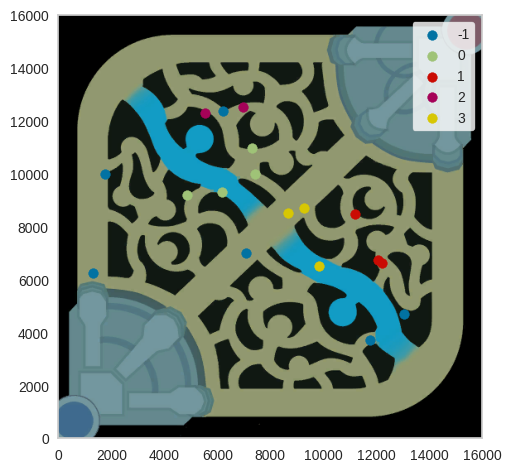

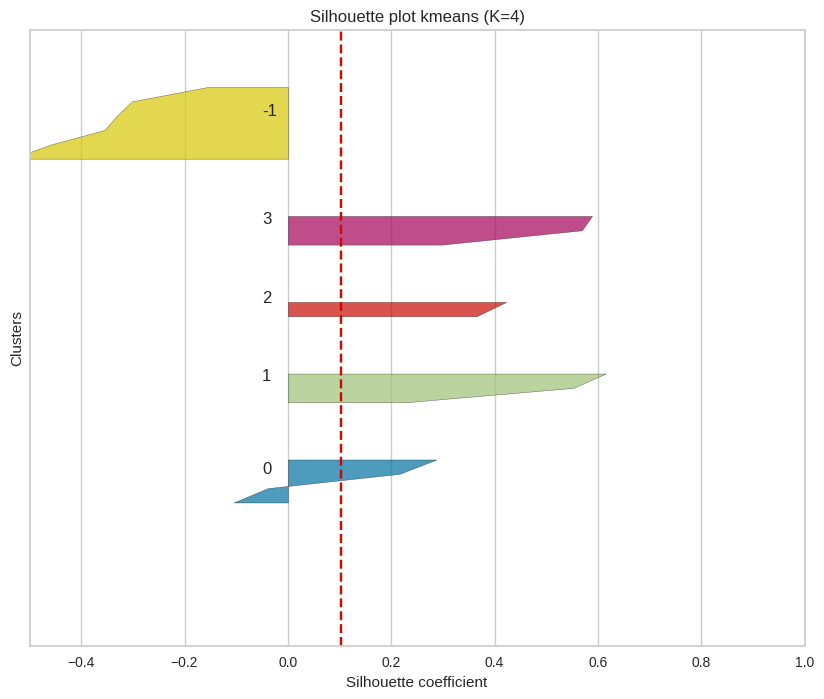

Kmeans silhouette_score 0.1035898268944409
--------------------------------------------------------------------------------------
17: EUW1_6154165838 - Red team Victory
Number of points:  27
[-1  0  1  2  3]
| Cluster -1|
Number of points in the cluster:  6 

Max Timestamp: 23.00775
Min Timestamp: 2.0005333333333333
Mean Timestamp: 10.837116666666667

Max position: (x:12480, y:12496)
Min position: (x:819, y:3796)
Mean position: (x:6324.166666666667, y:8867.333333333334)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  7 

Max Timestamp: 16.00545
Min Timestamp: 3.001033333333333
Mean Timestamp: 8.860235714285713

Max position: (x:13775, y:9064)
Min position: (x:9865, y:6361)
Mean position: (x:12065.857142857143, y:7403.285714285715)

--------------------------------------------------------------------------------

| Cluster 1|
Number of points in the cluster:  3 

Max Timestamp: 17.0059
Min Timestamp: 12.00

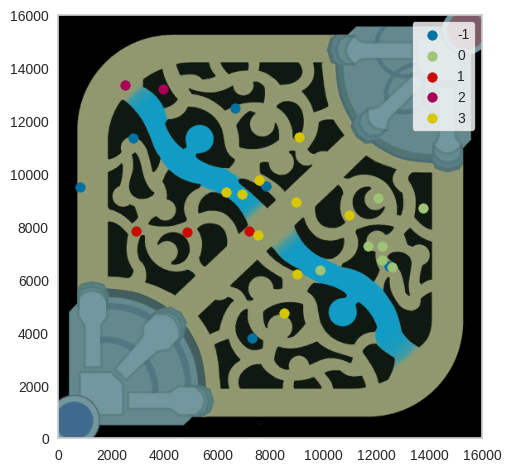

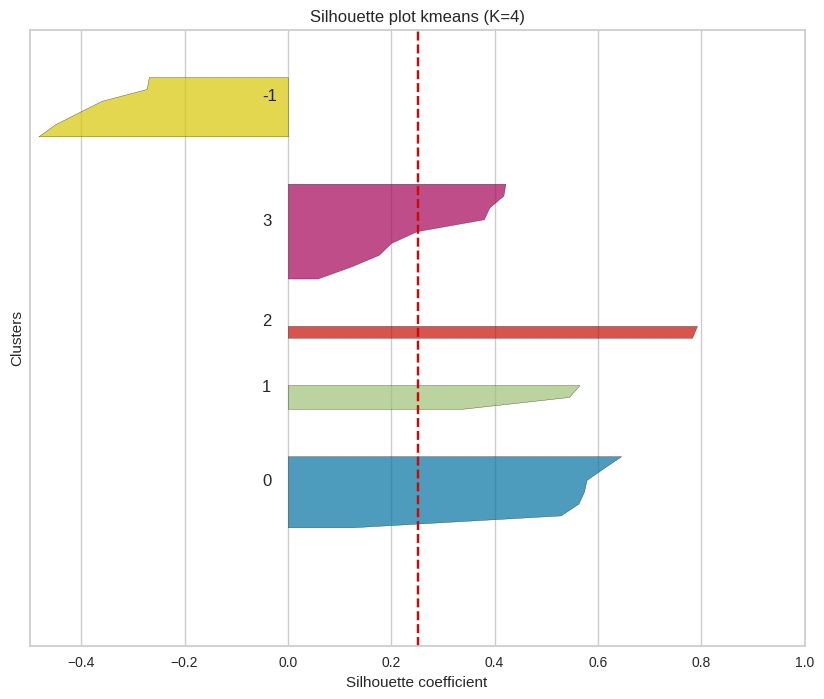

Kmeans silhouette_score 0.2522694912064412
--------------------------------------------------------------------------------------


In [33]:
n = 1
for game in redTeamWins_df.gameId.unique():
    game_df = df.loc[df["gameId"] == game]
    print("{}: {} - {} team Victory".format(n, game, game_df["team"].unique()[0]))
    print("Number of points: ", game_df.shape[0])
    clustering(game_df)
    n += 1

[-1  0]
| Cluster -1|
Number of points in the cluster:  2 

Max Timestamp: 31.0092
Min Timestamp: 4.001733333333333
Mean Timestamp: 17.505466666666667

Max position: (x:10972, y:13946)
Min position: (x:10439, y:1552)
Mean position: (x:10705.5, y:7749.0)

--------------------------------------------------------------------------------

| Cluster 0|
Number of points in the cluster:  372 

Max Timestamp: 33.01035
Min Timestamp: 1.0
Mean Timestamp: 13.430474329004316

Max position: (x:13775, y:13723)
Min position: (x:819, y:1042)
Mean position: (x:8017.794805194805, y:7974.825974025974)

--------------------------------------------------------------------------------



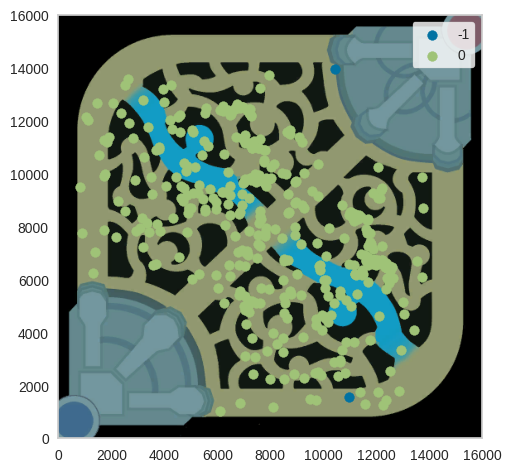

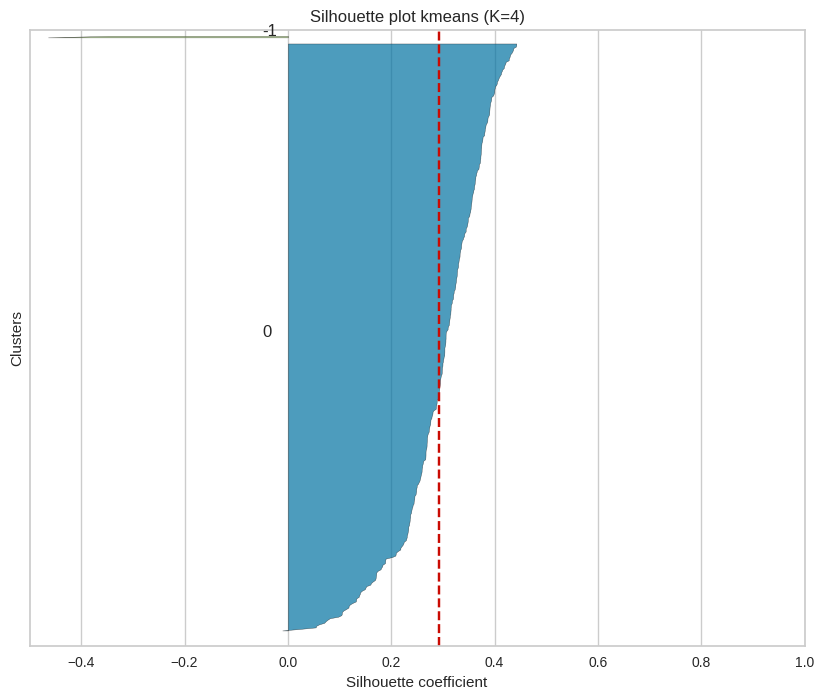

Kmeans silhouette_score 0.29318667405950694
--------------------------------------------------------------------------------------


In [34]:
clustering(redTeamWins_df)